*Над чем можно поработать:*

-автоматически подгонять тексты под формат (метаинформацию выделять метками)

-из-за формата кавычек может пойти что-то не так (привести к единому стилю оригинал и перевод)

-странно склеиваится 10 абзац на африкаанс

*Шаги на пробной одной главе:*

установка библиотеки

In [91]:
# !pip install lingtrain-aligner==0.8.7
# !pip install razdel dateparser sentence_transformers

In [92]:
# !pip install more-itertools 

#пришлось доустановить это, так как иначе не работали импорты из следующей ячейки

импорт необходимых для тренировки штук

In [2]:
import os
from lingtrain_aligner import preprocessor, splitter, aligner, resolver, reader, helper, vis_helper

читаем текст

In [72]:
text1_input = "AF-BOOKS-2011-Meyer-7dae-Chapter1.txt"
text2_input = "AF-BOOKS-2011-Meyer-7dae-EN-Chapter1.txt"

with open(text1_input, "r", encoding="utf8") as input1:
    text1 = input1.readlines()

with open(text2_input, "r", encoding="utf8") as input2:
    text2 = input2.readlines()

задаю путь до БД, где лежат: строки с выделенными абзацами и главами, метаданные, маппинг выровненных строк на их изначальный состав и местоположение

параметры языка lang_from и lang_to. Они влияют на правила разбиения строк на предложения

название модели, которую использую

In [73]:
db_path = "db/book.db"

lang_from = "afr" 
lang_to = "en"

#использую модель distiluse-base-multilingual-cased-v2

model_name = "sentence_transformer_multilingual"

cохраняю структуру абзацев и разобиваю на строки (готовые модули, очень удобно)

In [74]:
text1_prepared = preprocessor.mark_paragraphs(text1)
text2_prepared = preprocessor.mark_paragraphs(text2)

splitted_from = splitter.split_by_sentences_wrapper(text1_prepared , lang_from)
splitted_to = splitter.split_by_sentences_wrapper(text2_prepared , lang_to)

Создаю БД

In [75]:
if os.path.isfile(db_path):
    os.unlink(db_path)

aligner.fill_db(db_path, lang_from, lang_to, splitted_from, splitted_to)

Кака я поняла, выравнивание происходит кусками (batch) (отсюда следующий поинт: надо бы автоматизировать аккуратно, чтобы целиком за раз книгу или по мере обновления; как-то на ровные кусочки делить текст автоматически)

Размер находится в batch_size, вокруг каждого куска берется дополнительное количество строк размера window. Это нужно для того, чтобы точно соотнести строки необходимые. Модель использует векторные представления для лучшего подбора.

In [76]:
batch_ids = []

aligner.align_db(db_path, \
                model_name, \
                batch_size=200, \
                window=30, \
                batch_ids=batch_ids, \
                save_pic=False,
                embed_batch_size=50, \
                normalize_embeddings=True, \
                show_progress_bar=True
                )

batch: 0


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

отклонения, которые получились

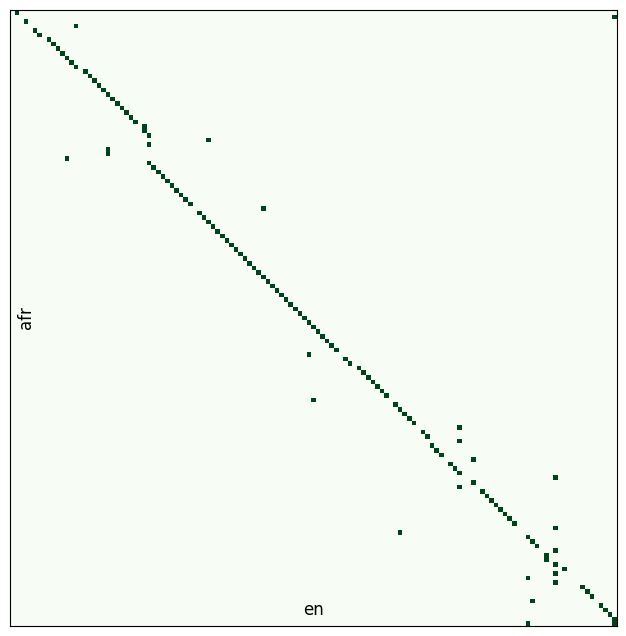

In [77]:
vis_helper.visualize_alignment_by_db(db_path, output_path="alignment_vis.png", lang_name_from=lang_from, lang_name_to=lang_to, batch_size=400, size=(800,800), plt_show=True)

Из-за чего это возникает? Количество предложений в текстах различается. 

Для исправления есть модуль resolver. Необходимо в определённых местах склеить вместе несколько предложений.

In [80]:
conflicts_to_solve, rest = resolver.get_all_conflicts(db_path, min_chain_length=2, max_conflicts_len=7, batch_id=-1)

resolver.get_statistics(conflicts_to_solve)
resolver.get_statistics(rest)

get_all_conflicts, handle_start: False handle_finish: False batch_id -1
conflicts to solve: 14
total conflicts: 15
('3:3', 7)
('2:3', 3)
('7:1', 1)
('3:2', 1)
('5:6', 1)
('4:4', 1)
('10:11', 1)


defaultdict(int, {'10:11': 1})

In [81]:
resolver.show_conflict(db_path, conflicts_to_solve[2]) 

#пример конфликта 3 на 3, в чём здесь проблема? Надо бы разобраться

26 As hy net een dop kan maak voor hy haar ontmoet.
27 Om te keer dat sy senuwees handuit ruk.
28 Hy sal sy hand eers aan sy nuwe broek moet afvee, want hy kan nie vir Lize Beekman groet as dit so gesweet is nie.


29 If he could just have one drink before he met her.
30 To keep his nerves from getting out of control.
31 He would have to dry his hand on his new trousers first, he couldn’t greet Lize Beekman with his palm all sweaty.
-----------------------------------------------


({26: 'As hy net een dop kan maak voor hy haar ontmoet.',
  27: 'Om te keer dat sy senuwees handuit ruk.',
  28: 'Hy sal sy hand eers aan sy nuwe broek moet afvee, want hy kan nie vir Lize Beekman groet as dit so gesweet is nie.'},
 {29: 'If he could just have one drink before he met her.',
  30: 'To keep his nerves from getting out of control.',
  31: 'He would have to dry his hand on his new trousers first, he couldn’t greet Lize Beekman with his palm all sweaty.'})

Как работает resolver: смотрит на все-все варианты, считает коэффициент похожести, берёт лучший из всех.

Как выравнивается: ищет минимальную цепочку предложений (2) и максимальную (7) (в conflicts to solve находятся выделенные мной конфликты (от 2 до 7 предложений). В целом, они не очень длинные и их не должно быть сложно решить программе, если же конфликт большой, то программа будет его разбивать на несколько и поэтому, нет смысла задавать прям большой объём максимальной цепочки)

В 3 шага должно всё точно получится (хотя надо бы посмотреть на большие объёмы текста, но, мне кажется, от этого ничего не изменится. У нас не возникнет конфликта на 21 - 25 предложений, это что-то странное, поэтому 3 проходов должно хватить)

get_all_conflicts, handle_start: False handle_finish: False batch_id -1
conflicts to solve: 13
total conflicts: 15


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.31it/s]


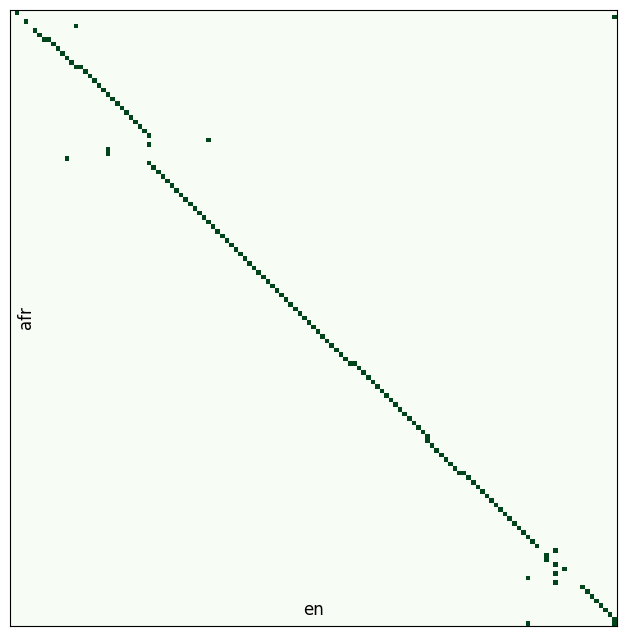

get_all_conflicts, handle_start: False handle_finish: False batch_id -1
conflicts to solve: 2
total conflicts: 2


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.75it/s]


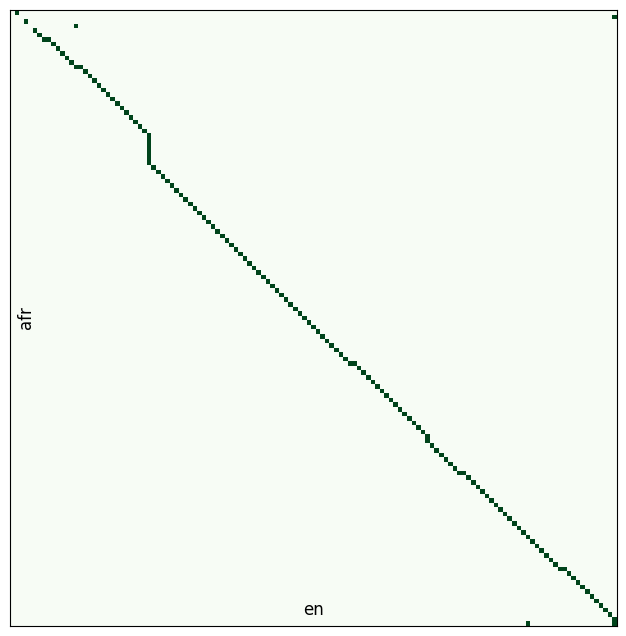

In [82]:
steps = 3

for i in range(steps):
    conflicts, rest = resolver.get_all_conflicts(db_path,
                        min_chain_length=2+i,
                        max_conflicts_len=6*(i+1),
                        batch_id=-1)

    resolver.resolve_all_conflicts(db_path, conflicts, model_name, show_logs=False)
    
    vis_helper.visualize_alignment_by_db(db_path, output_path="test.png", lang_name_from=lang_from, lang_name_to=lang_to, batch_size=400, size=(800,800), plt_show=True)

    if len(rest) == 0:
        break

ещё раз посмотрим на конфликты (чудно, их нет)

In [83]:
conflicts_to_solve, rest = resolver.get_all_conflicts(db_path, min_chain_length=2, max_conflicts_len=6, batch_id=-1)

resolver.get_statistics(conflicts_to_solve)
resolver.get_statistics(rest)

get_all_conflicts, handle_start: False handle_finish: False batch_id -1
conflicts to solve: 0
total conflicts: 0


defaultdict(int, {})

Тут собирается сам текст с выделенными предложениями, опять-таки есть встроенный модуль. Я пока не стала в это углубляться, но, думаю, при работе позже с интерфейсом я попробую поиграться с этим (если остановлюсь на lingtrain)

In [88]:
output_path = "result/chapter_1.html"
paragraphs, delimeters, metas, sent_counter = reader.get_paragraphs(
    db_path, direction="to"
)

In [89]:
my_style = [
    '{"background": "#A2E4B8", "color": "black", "border-bottom": "0px solid red"}',
    '{"background": "#FFC1CC", "color": "black"}',
    '{"background": "#9BD3DD", "color": "black"}',
    '{"background": "#FFFCC9", "color": "black"}'
    ]

lang_ordered = ["from", "to"]

In [90]:
reader.create_book(
    lang_ordered=lang_ordered,
    paragraphs=paragraphs,
    delimeters=delimeters,
    metas=metas,
    sent_counter=sent_counter,
    output_path=output_path,
    template="pastel_fill",
    styles=[],
)

Что в планах на следующую неделю:

-посмотреть на Bleualign и попробовать там проделать тоже самое, сравнить по времени (качество надо бы тоже оценить, пока думаю над этим)

-есть ещё вариант hunalign (но он вроде как немного устаревший, в любом случае, почитаю про это)

Что в планах на неделю 30.01 - 05.02:

-посмотреть на пословное выравнивание simalign (вопросы аналогично Bleualign)

Планы на февраль:

-определиться окончательно с библиотекой

-подумать над интерфейсом

-попробовать оптимизировать

Ощущения: это не так сложно, как я себе представляла; кажется, что это не прям тянет на курсовую, скорее на обычный проект по программированию... хотя, если задуматься больше над интерфейсом, но тогда мало "компьютерно-лингвистической" части. Возможно, у Вас есть какие-то мысли по этому поводу?